# eXponential Family Dynamical Systems (XFADS): Large-scale nonlinear Gaussian state-space modeling

<a target="_blank" href="https://colab.research.google.com/github/catniplab/xfads/blob/workshop/workshop/linear_ds/main.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<br>For a first simple glance of XFADS, we start with a walk-through example to explore its minimal functioning by applying it to synthesized data from a linear dynamical system. In [the next example](https://github.com/catniplab/xfads/blob/workshop/workshop/vanderpol/main.ipynb), we add non-linearity to the data and apply XFADS to data generated from the classical Vanderpol oscillator.<br>
If you feel comfortable dabbling with XFADS by directly applying it to neural data, you can jump to applying it to the `mc_maze` dataset at the [`monkey_reaching` example](https://github.com/catniplab/xfads/blob/workshop/workshop/monkey_reaching/eval.ipynb).<br>

For an in-depth understanding of the underlying theory of this statistical framework, dive into the paper: [Dowling, Zhao, Park. 2024](https://arxiv.org/abs/2403.01371). But if you are more into practicality and neural data analysis, it's enough to start with the examples!

## Installation
After cloning the repo, and installing anaconda, or miniconda, create the environment by running:<br>
`conda env create -f environment.yaml`<br>

Add the `xfads` package to the `PYTHONPATH` of the environment<br>
`pip install -e .`<br>

If you are on Google Colab, which is recommended, run the following cell to clone the repo and install the requirements, and you are ready to go!<br>
(Since Colab uses sessions anyway, it won't be that useful to use an environment.)

In [7]:
def is_running_in_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_running_in_colab():
    !git clone https://github.com/catniplab/xfads.git
    %cd xfads
    # install the dependencies
    !pip install torch pytorch-lightning scikit-learn hydra-core matplotlib einops
    # wrap the XFADS package
    !pip install -e .

In [9]:
import numpy as np
import math
import matplotlib.pyplot as plt
import hydra

import torch
import torch.nn as nn
import pytorch_lightning as lightning

import xfads.utils as utils
import xfads.plot_utils as plot_utils

from matplotlib import cm
from scipy.ndimage import gaussian_filter1d
from hydra import compose, initialize

from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint

from lds_utils import *

from xfads.ssm_modules.dynamics import DenseGaussianDynamics
from xfads.ssm_modules.likelihoods import GaussianLikelihood
from xfads.smoothers.lightning_trainers import LightningNonlinearSSM
from xfads.ssm_modules.dynamics import DenseGaussianInitialCondition
from xfads.ssm_modules.encoders import LocalEncoderLRMvn, BackwardEncoderLRMvn
from xfads.smoothers.lightning_trainers import LightningNonlinearSSM, LightningDMFCRSG
from xfads.smoothers.nonlinear_smoother_causal import NonlinearFilter, LowRankNonlinearStateSpaceModel

In [10]:
torch.cuda.empty_cache()

## Configuration

In [12]:
"""config"""

cfg = {
    # --- graphical model --- #
    'n_latents': 2,
    'n_latents_read': 2,

    'rank_local': 2,
    'rank_backward': 2,

    'Q_init': 1e-1,
    'n_hidden_dynamics': 64,

    # --- inference network --- #
    'n_samples': 5,
    'n_hidden_local': 128,
    'n_hidden_backward': 64,

    # --- hyperparameters --- #
    'use_cd': False,
    'p_mask_a': 0.0,
    'p_mask_b': 0.0,
    'p_mask_apb': 0.0,
    'p_mask_y_in': 0.0,
    'p_local_dropout': 0.4,
    'p_backward_dropout': 0.0,

    # --- training --- #
    'device': 'cpu',
    'data_device': 'cpu',

    'lr': 1e-3,
    'n_epochs': 50,
    'batch_sz': 128,

    # --- misc --- #
    'bin_sz': 20e-3,
    'bin_sz_ms': 20,
    'n_bins_bhv': 22,

    'seed': 1234,
    'default_dtype': torch.float32,

    # --- ray --- #
    'n_ray_samples': 10,
}


class DictAsAttributes(dict):

    def __getattr__(self, attr):
        if attr in self:
            return self[attr]
        else:
            raise AttributeError(f"'DictAsAttributes' object has no attribute '{attr}'")


# Create an instance of DictAsAttributes
cfg = DictAsAttributes(cfg)

In [16]:
lightning.seed_everything(cfg.seed, workers=True)
torch.set_default_dtype(torch.float32)

Seed set to 1234


## Generating the data
For this example, we will use data that is synthesized from a simple linear dynamical system. Then we will infer the posterior distribution of the latent factors that govern the low-dimensional underlying dynamics of the data, by learning a graphical state space model of the principal latents and the observations.

In [19]:
# n_trials x n_time_bins x n_neurons

"""generate data -- 2d oscillator with decay"""
n_trials = 500
n_neurons = 100
n_time_bins = 100

A = nn.Linear(cfg.n_latents, cfg.n_latents, bias=False, device=cfg.device)
A.weight.data = 0.9 * utils.make_2d_rotation_matrix(math.pi/4, device=cfg.device)
C = nn.Linear(cfg.n_latents, n_neurons, bias=True, device=cfg.device).requires_grad_(False)
Q_0_diag = torch.ones(cfg.n_latents, device=cfg.device)
Q_diag = torch.ones(cfg.n_latents, device=cfg.device)
R_diag = torch.ones(n_neurons, device=cfg.device)
m_0 = torch.zeros(cfg.n_latents, device=cfg.device)

z = utils.sample_gauss_z(A, Q_diag, m_0, Q_diag, n_trials, n_time_bins)
y = C(z) + torch.sqrt(R_diag) * torch.randn((n_trials, n_time_bins, n_neurons), device=cfg.device)
y = y.detach()

y_train, z_train = y[:n_trials//2], z[:n_trials//2]
y_valid, z_valid = y[n_trials//2:], z[n_trials//2:]

y_train_dataset = torch.utils.data.TensorDataset(y_train,)
y_valid_dataset = torch.utils.data.TensorDataset(y_valid,)
train_dataloader = torch.utils.data.DataLoader(y_train_dataset, batch_size=cfg.batch_sz, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(y_valid_dataset, batch_size=cfg.batch_sz, shuffle=True)

In [21]:
# indices of n example trials
n_ex_trial = 4
ex_trials = np.random.choice(range(0, y_valid.shape[0]), size=n_ex_trial, replace=False)

# indices of n example neuron
n_ex_neurons = 4
ex_neurons = np.random.choice(range(0, y_valid.shape[2]), size=4, replace=False)

# top n neurons to plot wihen visualizing trials
top_n_neurons = n_neurons

<Figure size 1600x600 with 0 Axes>

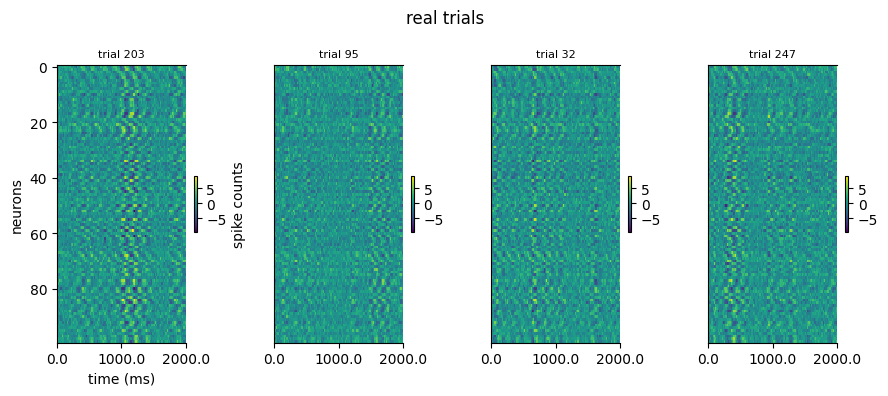

In [23]:
plot_rastor(y_valid, cfg, ex_trials, y_valid.shape[2])

## Structuring the state-space model
The modules of the XFADS package are organized in a modular way, allowing the users to change and plug in their own definitions of the classes that structure the elements of the model, i.e. the dynamics function, the likelihood density, the amortization network, etc.

The configuration depends on the problem - `dynamics_mod`, `initial_c_pdf`, `likelihood_pdf`, `local_encoder`, and `backward_encoder` can be configured as desired. We include some general classes in `ssm_modules/encoders`, `ssm_modules/likelihoods`, and `ssm_modules/dynamics` that should be sufficient for a wide range of problems.  Below is an example configuration.

In each iteration of the variational inference, we need to optimize the parameters of the approximate posterior, which can be quite inefficient, to enable amortized inference for the state-space model, we follow the technique of using a trainable NN, known as an **inference network** or **recognition network**, to predict these parameters from the observed data.

A possible drawback of the traditional inference frameworks is that missing observations obstruct inference, i.e. cannot naturally accommodate missing data. But in a state-space graphical model, the latent state posterior should be accessible for every time point even with missing observations. To enable the amortized inference network to process missing observations in a principled way, we decompose the natural parameter update into two additive components: i) a **local encoder**, for current observation, and ii) a **backward encoder**, for future observations.

For a detailed step-by-step development of XFADS, check the Method section of [the paper](https://arxiv.org/abs/2403.01371).

In [26]:
"""likelihood pdf"""
likelihood_pdf = GaussianLikelihood(C, n_neurons, R_diag, device=cfg.device)

"""dynamics module"""
dynamics_fn = utils.build_gru_dynamics_function(cfg.n_latents, cfg.n_hidden_dynamics, device=cfg.device)
dynamics_mod = DenseGaussianDynamics(dynamics_fn, cfg.n_latents, Q_diag, device=cfg.device)

"""initial condition"""
initial_condition_pdf = DenseGaussianInitialCondition(cfg.n_latents, m_0, Q_0_diag, device=cfg.device)

"""local/backward encoder"""
backward_encoder = BackwardEncoderLRMvn(cfg.n_latents, cfg.n_hidden_backward, cfg.n_latents,
                                        rank_local=cfg.rank_local, rank_backward=cfg.rank_backward,
                                        device=cfg.device)
local_encoder = LocalEncoderLRMvn(cfg.n_latents, n_neurons, cfg.n_hidden_local, cfg.n_latents, rank=cfg.rank_local,
                                  device=cfg.device, dropout=cfg.p_local_dropout)
nl_filter = NonlinearFilter(dynamics_mod, initial_condition_pdf, device=cfg.device)

"""sequence vae"""
ssm = LowRankNonlinearStateSpaceModel(dynamics_mod, likelihood_pdf, initial_condition_pdf, backward_encoder,
                                      local_encoder, nl_filter, device=cfg.device)

"""lightning"""
seq_vae = LightningNonlinearSSM(ssm, cfg)
# seq_vae = LightningNonlinearSSM.load_from_checkpoint('ckpts/epoch=471_valid_loss=14513.6044921875.ckpt', ssm=ssm, cfg=cfg)

csv_logger = CSVLogger('logs/', name=f'r_y_{cfg.rank_local}_r_b_{cfg.rank_backward}', version='noncausal')
ckpt_callback = ModelCheckpoint(save_top_k=3, monitor='valid_loss', mode='min', dirpath='ckpts/',
                                filename='{epoch:0}_{valid_loss}')

# Show model structure
seq_vae

LightningNonlinearSSM(
  (ssm): LowRankNonlinearStateSpaceModel(
    (nl_filter): NonlinearFilter(
      (dynamics_mod): DenseGaussianDynamics(
        (mean_fn): DynamicsGRU(
          (gru_cell): GRUCell(0, 64)
          (h_to_z): Linear(in_features=64, out_features=2, bias=True)
          (z_to_h): Linear(in_features=2, out_features=64, bias=True)
        )
      )
      (initial_c_pdf): DenseGaussianInitialCondition()
    )
    (dynamics_mod): DenseGaussianDynamics(
      (mean_fn): DynamicsGRU(
        (gru_cell): GRUCell(0, 64)
        (h_to_z): Linear(in_features=64, out_features=2, bias=True)
        (z_to_h): Linear(in_features=2, out_features=64, bias=True)
      )
    )
    (local_encoder): LocalEncoderLRMvn(
      (mlp): Sequential(
        (0): Linear(in_features=100, out_features=128, bias=True)
        (1): SiLU()
        (2): Dropout(p=0.4, inplace=False)
        (3): Linear(in_features=128, out_features=6, bias=True)
      )
    )
    (initial_c_pdf): DenseGaussianInit

## Training and saving the model

In [ ]:
trainer = lightning.Trainer(max_epochs=cfg.n_epochs,
                            gradient_clip_val=1.0,
                            default_root_dir='lightning/',
                            callbacks=[ckpt_callback],
                            logger=csv_logger
                            )

trainer.fit(model=seq_vae, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)
torch.save(ckpt_callback.best_model_path, 'ckpts/best_model_path.pt')

## Loading the trained model

In [29]:
seq_vae = LightningNonlinearSSM.load_from_checkpoint(f'ckpts/epoch=49_valid_loss=15159.97265625.ckpt', ssm=ssm, cfg=cfg)

## Evaluating the model
First, let's compare the latents inferred by XFADS, from the data, with the original two dimensions of the dynamical system that was used to generate the high-dimentional data. 

In [32]:
loss, z, stats = seq_vae.ssm(y_valid, cfg.n_samples)

In [33]:
stats.keys()

dict_keys(['kl', 'm_s', 'm_f', 'm_p', 'Psi_f', 'Psi_p'])

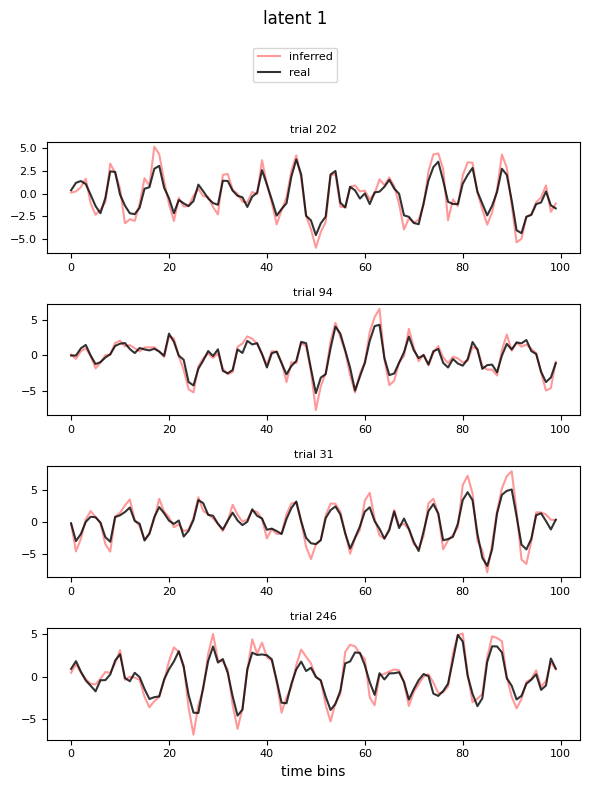

In [34]:
plot_latent_trajectory(z_valid, stats['m_f'], ex_trials, latent_idx=0)

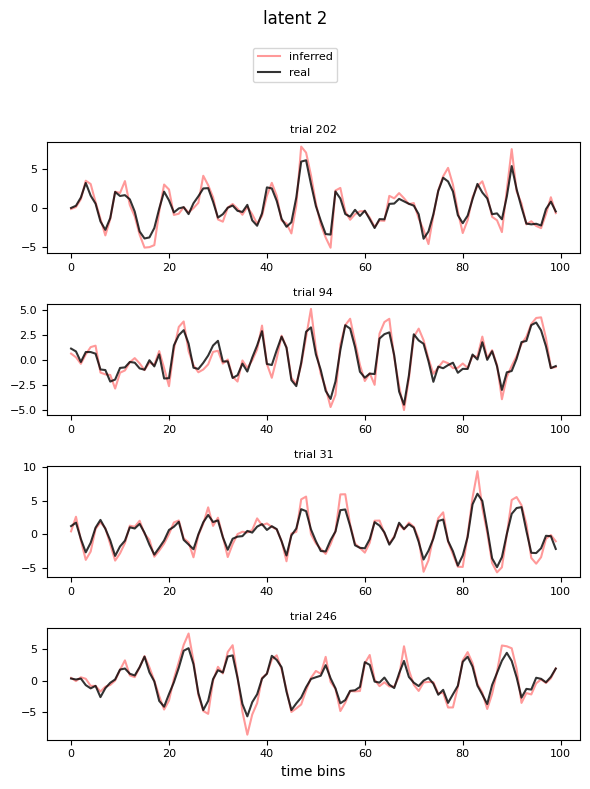

In [35]:
plot_latent_trajectory(z_valid, stats['m_f'], ex_trials, latent_idx=1)

/var/folders/py/p6knbk5d2qzdvstddyrnfym80000gn/T/ipykernel_2808/4148023273.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


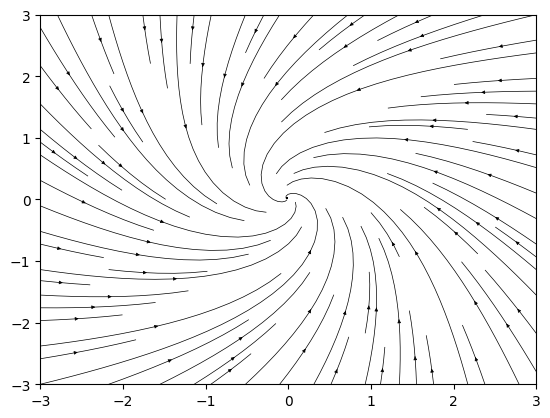

In [40]:
fig, axs = plt.subplots()
plot_utils.plot_two_d_vector_field(seq_vae.ssm.dynamics_mod.mean_fn, axs)
fig.show()

## Filtering, Smoothing, and Prediction
There is a trick we worked on to conceptualize the approximate smoothing problem as an approximate filtering problem for pseudo-observations that encode a representation of current and future data.

We draw inspiration from a quintessential facet of conjugate Bayesian inference: natural parameters of the posterior are a sum-separable combination of the natural parameters of the prior in addition to a data-dependent term. The latter can now be thought of as a data-dependent update to the prior for a conjugate pseudo-observation.

Importantly, pseudo-observations defined this way encode the current *and* future observations of the raw data – an essential component for transforming the statistical smoothing problem into an alternative filtering problem.

The next figure illustrates the smoothing and predictive performance of XFADS trained on the data generated from an LDS. To the left of the red line are samples from the posterior during the data window, and to the right of the red line are samples unrolled from $p_{\theta}(z_t | z_{t-1})$.

So, we end up with three regimes:
**Filtering** `stats['m_f']`, **Smoothing** `stats['m_s']`, and **Prediction** `stats['m_p']`.

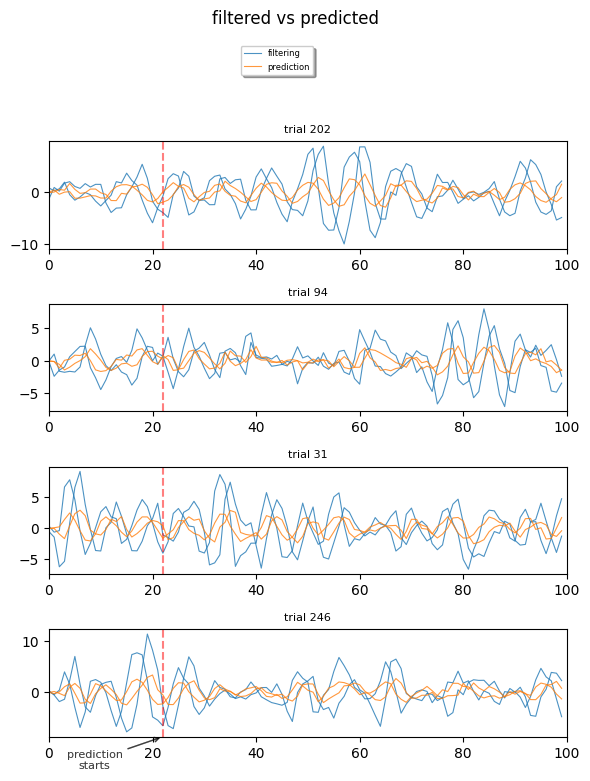

In [43]:
with torch.no_grad():

    fig, axs = plt.subplots(len(ex_trials), 1, figsize=(6, 8))
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    plot_z_2d(fig, axs, ex_trials, stats['m_f'][ex_trials], cfg, color=default_colors[0], regime='filtering')
    plot_z_2d(fig, axs, ex_trials, stats['m_p'][ex_trials], cfg, color=default_colors[1], regime='prediction')
    
    fig.suptitle('filtered vs predicted\n\n\n\n')
    fig.tight_layout()
    
    fig.legend(loc='upper center', bbox_to_anchor=(0.47, 0.94), shadow=True, ncol=1, fontsize=6)
    
    plt.show()

## Generating corresponding observations

In [46]:
# smoothed and predicted log rates
r_s = seq_vae.ssm.to(cfg.data_device).likelihood_pdf.readout_fn(stats['m_s'])
r_p = seq_vae.ssm.to(cfg.data_device).likelihood_pdf.readout_fn(stats['m_p'])

# sampeling from the rates log possion to get the spike counts
y_s = torch.poisson(cfg.bin_sz * torch.exp(r_s))
y_p = torch.poisson(cfg.bin_sz * torch.exp(r_p))

y_hat = torch.cat([y_s[:, :, :], y_p], dim=2)
z_hat = torch.cat([stats['m_s'][:, :, :], stats['m_p']], dim=2)

<Figure size 1600x600 with 0 Axes>

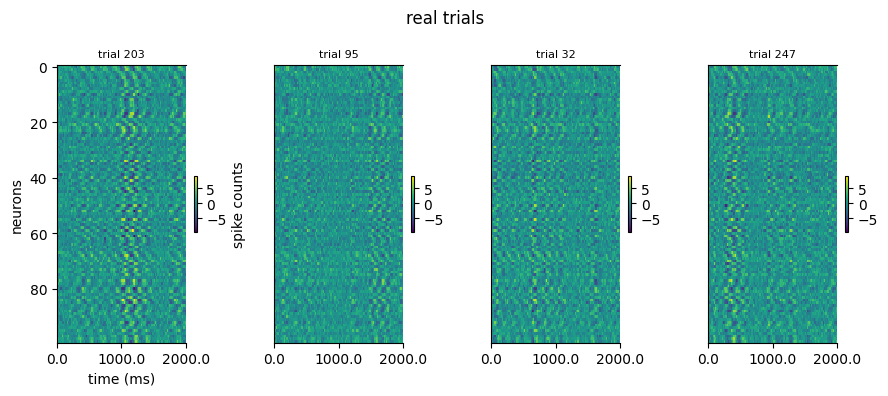

<Figure size 1600x600 with 0 Axes>

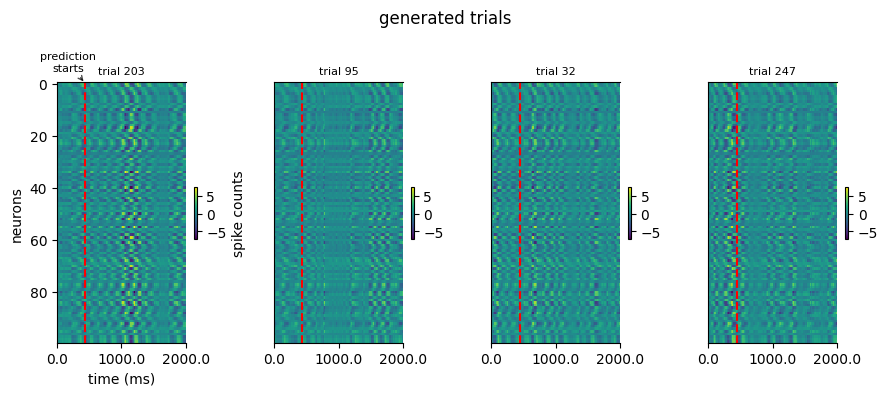

In [101]:
plot_rastor(y_valid, cfg, ex_trials, y_valid.shape[2], regime='real', order=False, latents=y_p)
plot_rastor(r_s, cfg, ex_trials, y_valid.shape[2], regime='prediction', order=False, latents=y_p)

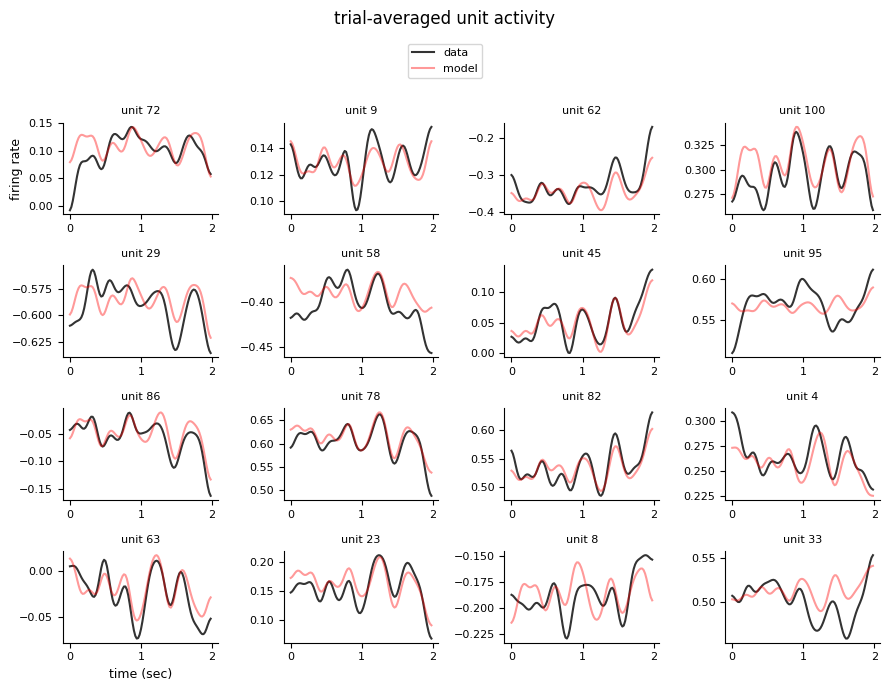

In [60]:
with torch.no_grad():

    n_eurons_to_plot = 16
    neuron_incs = np.random.choice(range(0, y_valid.shape[2]), size=n_eurons_to_plot, replace=False)

    fig, axes = plt.subplots(int(np.sqrt(n_eurons_to_plot)), int(np.sqrt(n_eurons_to_plot)), figsize=(9, 7))
    fig.suptitle(f'trial-averaged unit activity\n\n\n')

    for ax, neuron in zip(axes.flat, neuron_incs):
        
        x = np.arange(n_time_bins) * cfg.bin_sz

        fr_data = torch.tensor(
            gaussian_filter1d(
                torch.mean(y_valid[:, :, neuron], axis=0),
                sigma=4, axis=0))

        fr_model= torch.tensor(
            gaussian_filter1d(
                torch.mean(r_s, axis=0)[:, neuron],
                sigma=4, axis=0))

        ax.plot(x, fr_data, color= 'black', alpha=0.8, label='data' if neuron == neuron_incs[-1] else '')
        ax.plot(x, fr_model, color= 'red', alpha=0.4, label='model' if neuron == neuron_incs[-1] else '')

        ax.set_title(f'unit {neuron+1}', fontsize=8)
        ax.set_xlabel('time (sec)' if neuron == neuron_incs[-int(np.sqrt(n_eurons_to_plot))] else '', fontsize=9)
        ax.set_ylabel('firing rate' if neuron == neuron_incs[0] else '', fontsize=9)
        ax.tick_params(axis='x', labelsize=8)
        ax.tick_params(axis='y', labelsize=8)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.94), ncol=1, fontsize=8)
    fig.tight_layout()

plt.show()

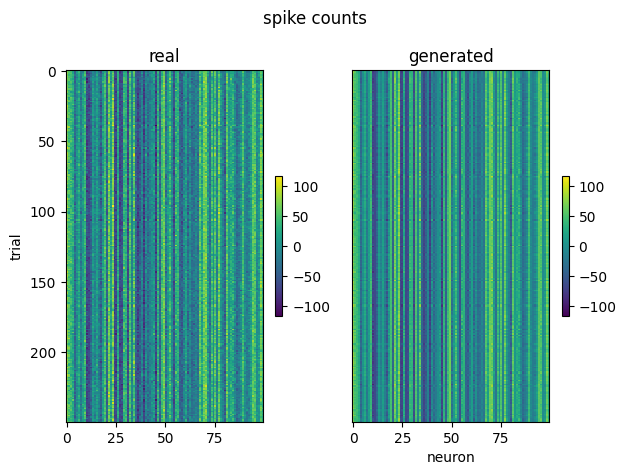

In [84]:
data_spike_count = torch.sum(y_valid, axis=1)
model_spike_count = torch.sum(r_s, axis=1)

fig, axs = plt.subplots(ncols=2)
fig.suptitle('spike counts')

with torch.no_grad():
    
    axs[0].set_title('real')
    dsc = axs[0].imshow(data_spike_count, interpolation='none', aspect='auto')
    axs[1].set_title('generated')
    msc = axs[1].imshow(model_spike_count, interpolation='none', aspect='auto')

    vmin, _ = min(torch.min(data_spike_count.flatten(), dim=0), torch.min(model_spike_count.flatten(), dim=0))
    vmax, _ = max(torch.max(data_spike_count.flatten(), dim=0), torch.max(model_spike_count.flatten(), dim=0))

    fig.colorbar(dsc, ax=axs[0], shrink=0.4).mappable.set_clim(vmin=vmin, vmax=vmax)
    fig.colorbar(msc, ax=axs[1], shrink=0.4).mappable.set_clim(vmin=vmin, vmax=vmax)
                
axs[1].set_xlabel('neuron')
axs[0].set_ylabel('trial')

axs[1].set_yticks([])

plt.tight_layout()

plt.show()

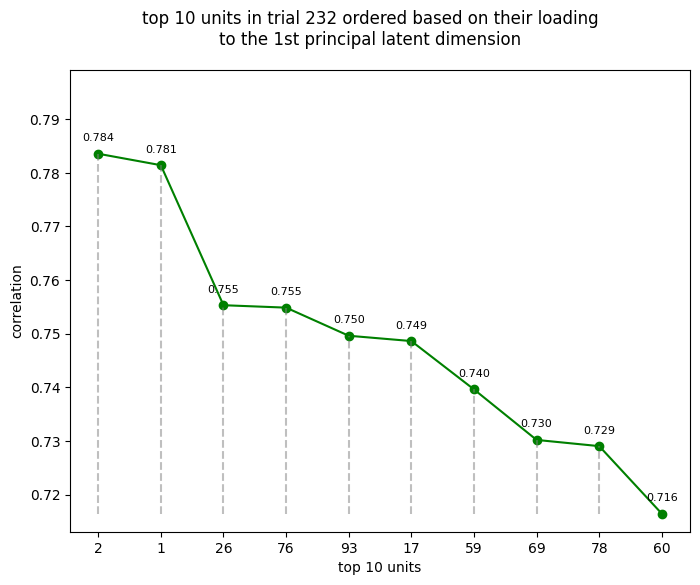

In [131]:
trial_idx = np.random.randint(0, y_valid.shape[0])
ordered_correlations, ordered_neurons = order_neurons(y_valid, stats['m_f'], trial=trial_idx, latent=0)

top_n = 10

time_bins = [str(i) for i in ordered_neurons[:top_n].astype('int32')]

y = np.abs(ordered_correlations.T[1][:top_n])

plt.ion()

fig, axes = plt.subplots(figsize=(8, 6))

axes.plot(time_bins, y, marker='o', linestyle='-', color='g')

for i in range(len(time_bins)):
    plt.text(time_bins[i], y[i]+0.002, f'{y[i]:.3f}', ha='center', va='bottom', fontsize=8)
    plt.vlines(i, ymin=y.min(), ymax=y[i], linestyles='dashed', colors='gray', alpha=0.5)

fig.suptitle(f'top 10 units in trial {trial_idx+1} ordered based on their loading\nto the 1st principal latent dimension\n\n\n\n')
plt.ylim(top=y.max()+0.02*y.max())

plt.xlabel('top 10 units')
plt.ylabel('correlation')

plt.show()